## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date
from scipy import stats
from livelossplot import PlotLossesKeras

import keras.models as models
import keras.layers as layers
from keras.layers.advanced_activations import LeakyReLU, PReLU, ThresholdedReLU, ELU

np.random.seed(101)

Using TensorFlow backend.


## Data loading

In [7]:
df = pd.read_csv("notNiteeshData.csv")
df = df.drop(list(range(365,400)))
df = df[df['ES_POPCORN SMALL']!=0]
df = df.reset_index(drop=True)

In [8]:
def create_timestepped_data(data_frame, time_steps):
    d = []
    for i in range(time_steps):
        d.append(data_frame.shift(-i).values[:-time_steps])
    return np.transpose(np.array(d),(1,0,2))

In [9]:
time_steps = 21
num_features = 5
data = df[['tamil','english','hindi','others','ES_POPCORN SMALL']]
data_norm = (data - data.min())/(data.max() - data.min())
# data = (data - data.mean())/ data.std()

In [10]:
d = create_timestepped_data(pd.DataFrame(data_norm),time_steps)
chosen = list(range(time_steps))
chosen.remove(int(time_steps/2))
x = d[:,chosen,:]
cur_x = x[:,int(time_steps/2),:-1]
cur_x = np.concatenate((cur_x.reshape(-1,1,4),np.zeros(shape=(cur_x.shape[0],1,252))),axis=-1)
y = d[:,int(time_steps/2),-1] * (data.max()[-1] - data.min()[-1]) + data.min()[-1]
# occ = occ[time_steps:]
train_split = int(0.7*x.shape[0])
x_train, x_test, y_train, y_test, cur_x_train, cur_x_test = x[:train_split], x[train_split:], y[:train_split], y[train_split:], cur_x[:train_split], cur_x[train_split:]
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, cur_x_train.shape, cur_x_test.shape)

(645, 20, 5) (645,) (277, 20, 5) (277,) (645, 1, 256) (277, 1, 256)


## Model building

In [2]:
def model_construct(input_shape1, input_shape2):
    
    inp = layers.Input(shape=(input_shape1))
    cur_inp = layers.Input(shape=(input_shape2))
    x = layers.Conv1D(256,kernel_size=3)(inp)
    #x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(256,kernel_size=2)(x)
    x = layers.Dense(256)(x)
    cnn_out = layers.Dropout(0.2)(x)
    
    lstm_inp = layers.Concatenate(axis=1)([cnn_out,cur_inp])
    
    x1 = layers.Bidirectional(layers.LSTM(832,unroll=True, return_sequences=True))(lstm_inp)
    x1 = layers.Dense(516)(x1)
    x1 = layers.Dropout(0.2)(x1)
    x1 = layers.Bidirectional(layers.LSTM(832,unroll=True, return_sequences=True))(x1)
    x1 = layers.Dense(516)(x1)
    x1 = layers.Dropout(0.2)(x1)
    x1 = layers.Bidirectional(layers.LSTM(832,unroll=True, return_sequences=True))(x1)
    x1 = layers.TimeDistributed(layers.Dense(256))(x1)
    lstm_out = layers.TimeDistributed(layers.Dropout(0.2))(x1)
    
    x1 = layers.Concatenate(axis=1)([lstm_out,cnn_out])
    x1 = layers.Flatten()(x1)
    
    x1 = layers.Dense(1024)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.Dense(1024)(x1)
    main_out = layers.Dense(1)(x1)
    
    model = models.Model(inputs=[inp,cur_inp], outputs=[main_out], name='CLDNN')
    model.summary()
    model.compile(optimizer='adam',loss='mse',metrics=['mae'])
    return model

In [3]:
model = model_construct(x_train.shape[1:],cur_x_train.shape[1:])

NameError: name 'x_train' is not defined

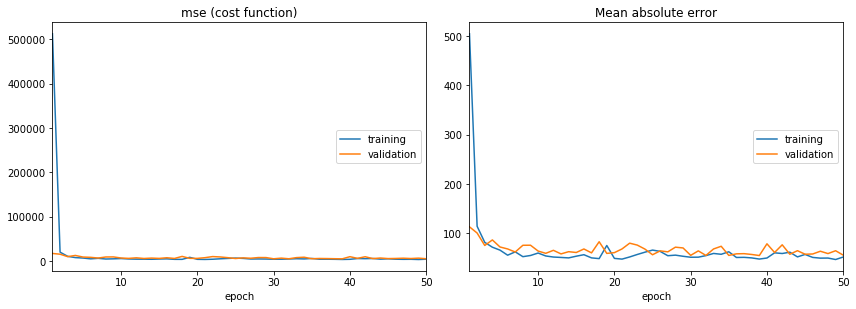

516/516 [==============================] - 5s - loss: 4483.4041 - mean_absolute_error: 52.2807 - val_loss: 5567.8810 - val_mean_absolute_error: 56.1252


In [8]:
model.fit([x_train,cur_x_train],y_train,epochs=50,validation_split=0.2,callbacks=[PlotLossesKeras()])

In [9]:
# rescaling
y_pred = model.predict([x_test, cur_x_test], batch_size=32)
pred = pd.Series(y_pred.reshape((-1,)))
# y_pred = ((y_pred - y_pred.min())*(dmax - dmin)/(y_pred.max() - y_pred.min())) + dmin
test = pd.Series(y_test.reshape((-1,)))
# y_test = ((y_test - y_test.min())*(dmax - dmin)/(y_test.max() - y_test.min())) + dmin

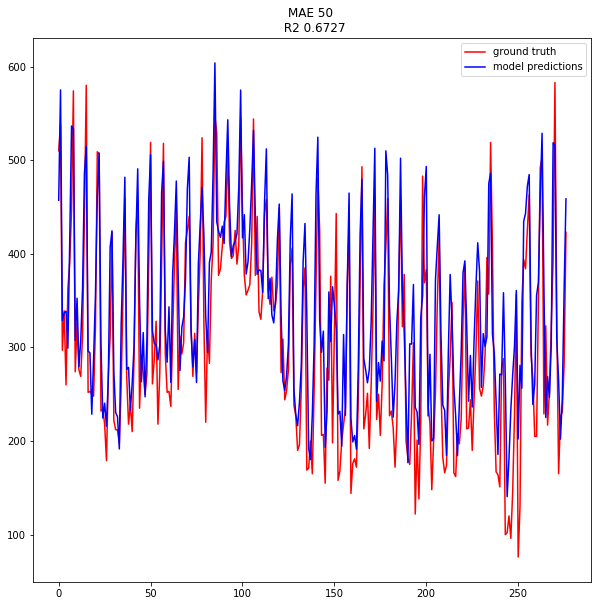

In [14]:
from sklearn.metrics import mean_absolute_error, r2_score
plt.figure(figsize=(10,10))
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test,pred), r2_score(test,pred)))
#plt.plot(y, color='r', label='ground truth')
plt.plot(test.index, test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

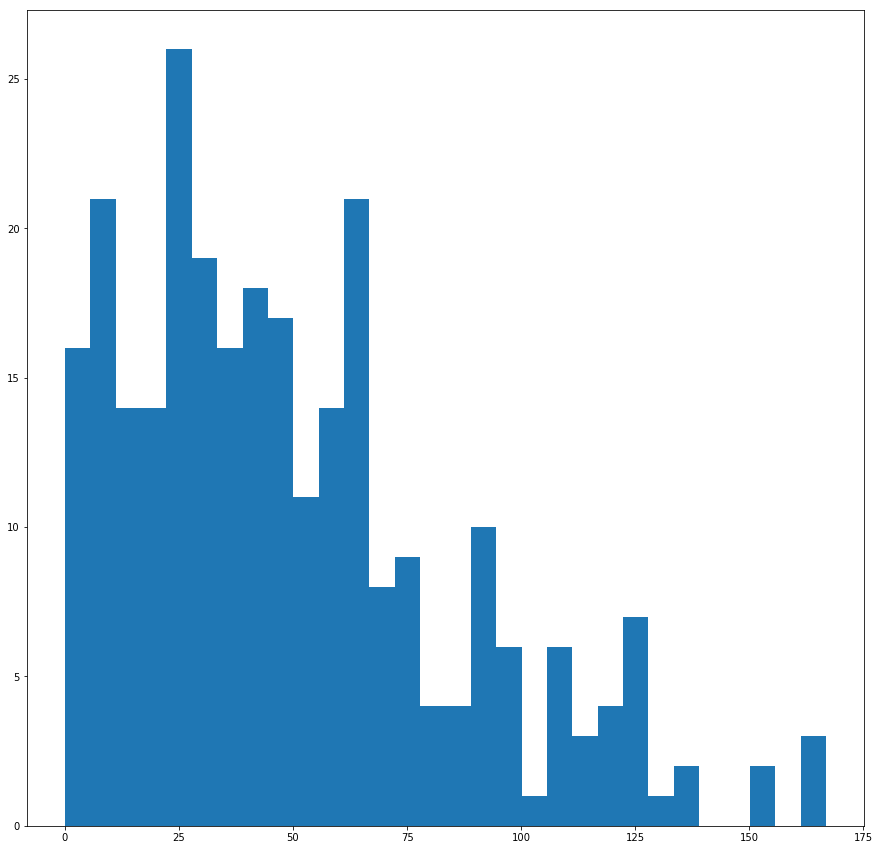

In [17]:
plt.figure(figsize=(15,15))
plt.hist(np.abs(pred-test), bins=30)
plt.show()

# Airport csv


In [ ]:
data = pd.read_csv('Time Series datasets/AirPassengers.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('Time Series datasets/AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print(data.head())

data.index

ts = data['#Passengers'] 
ts.head(10)

#1. Specific the index as a string constant:
ts['1949-01-01']

#2. Import the datetime library and use 'datetime' function:
from datetime import datetime
ts[datetime(1949,1,1)]

#1. Specify the entire range:
ts['1949-01-01':'1949-05-01']

#2. Use ':' if one of the indices is at ends:
ts[:'1949-05-01']

ts['1949']
# plt.plot(ts)

d = create_timestepped_data(pd.DataFrame(ts), 8)
x = d[:,:-1,:].reshape(-1,7,1)
cur_x = x[:,-1,:].reshape(-1,1,1)
cur_x = np.concatenate((cur_x.reshape(-1,1,1),np.zeros(shape=(cur_x.shape[0],1,255))),axis=-1)
y = d[:,-1,:].reshape(-1,1)

x.shape, y.shape, cur_x.shape

model1 = model_construct(x.shape[1:], cur_x.shape[1:])

model1.fit([x[:100], cur_x[:100]], y[:100], epochs=50, batch_size=32, validation_data=([x[100:],cur_x[100:]],y[100:]))

pred = model1.predict([x[100:],cur_x[100:]])
pred = pred.reshape((-1,))
test = y[100:].reshape((-1,))

from sklearn.metrics import mean_absolute_error, r2_score
plt.figure(figsize=(10,10))
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test,pred), r2_score(test,pred)))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 7, 1)         0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5, 256)       1024        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)     

Epoch 13/50
100/100 [==============================] - 2s 21ms/step - loss: 153790.6556 - mean_absolute_error: 334.7670 - val_loss: 402706.5417 - val_mean_absolute_error: 629.8010
Epoch 14/50
100/100 [==============================] - 2s 21ms/step - loss: 122390.5416 - mean_absolute_error: 318.6230 - val_loss: 65261.4722 - val_mean_absolute_error: 248.3077
Epoch 15/50
100/100 [==============================] - 2s 21ms/step - loss: 60522.3835 - mean_absolute_error: 209.9803 - val_loss: 116181.5156 - val_mean_absolute_error: 324.8108
Epoch 16/50
100/100 [==============================] - 2s 21ms/step - loss: 44661.4019 - mean_absolute_error: 188.4889 - val_loss: 42343.8924 - val_mean_absolute_error: 194.4515
Epoch 17/50
100/100 [==============================] - 2s 21ms/step - loss: 19474.0639 - mean_absolute_error: 124.9709 - val_loss: 6214.2750 - val_mean_absolute_error: 68.7048
Epoch 18/50
100/100 [==============================] - 2s 21ms/step - loss: 10210.2666 - mean_absolute_error